<H1>Intro</h1>My girlfriend and I got into a debate because I thought white ducks and white geese were the same animals. After a quick Google search, I found out that they’re not. But rather than end it there, I decided to build an AI model to tell the difference between ducks, geese, and swans for me!

In [37]:
# This block checks for internet connectivity in Kaggle notebooks, as you need an active connection to download necessary libraries and datasets.
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [38]:
# Ensure we're using the latest versions of the fastai and duckduckgo_search libraries.
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

<h1>Searching and downloading images</h1>
To train the model, I need images of ducks, geese, and swans. Instead of manually collecting them, I wrote a function to search for these images online using DuckDuckGo.

In [59]:
#Load our ddg search, fast core, and vision learner items

from duckduckgo_search import DDGS #ddg_images (Deprecated 11-2023)
from fastcore.all import *
from fastai.vision.all import *

In [40]:
# Function to search and download images from DuckDuckGo

def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term,max_results=max_images)).itemgot('image')

In [41]:
# Test the function by searching for a duck image
results = search_images('duck', max_images=1)
results[0]

Searching for 'duck'


'http://upload.wikimedia.org/wikipedia/commons/7/74/White_domesticated_duck,_stretching.jpg'

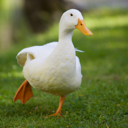

In [42]:
# Download the first duck image and preview it

from fastdownload import download_url

# Set the destination for the downloaded image
destination = 'duck.jpg'
download_url(results[0],destination,show_progress=False)

# Open the downloaded image and show it as a thumbnail
imageExample = Image.open(destination)
imageExample.to_thumb(128,128)

<h1>Preparing the dataset</h1>
Now that I have the search function working, I’ll download images for ducks, geese, and swans. The goal is to gather enough data to train a model that can distinguish between them.

In [43]:
# Define the categories (duck, goose, swan)
waterfowl_types = 'duck', 'goose', 'swan'
path = Path('waterfowl')

In [44]:
# Create a folder to store the images if it doesn't exist
if not path.exists():
    path.mkdir()

In [45]:
# Download images for each waterfowl category
for categories in waterfowl_types:
    categoryDestination = (path/categories)
    categoryDestination.mkdir(exist_ok=True)
    download_images(categoryDestination,urls=search_images(f'{categories} white'))

print('Image download complete.')

Searching for 'duck white'
Searching for 'goose white'
Searching for 'swan white'
Image download complete.


In [46]:
# Check if the images downloaded successfully
fns = get_image_files(path)
fns

(#143) [Path('waterfowl/goose/5e482301-07d4-42a7-b2bb-c0cf9d923317.jpg'),Path('waterfowl/goose/404d80ff-9dfb-4fa1-92fe-97427a842b8b.jpg'),Path('waterfowl/goose/6e21337e-9c2e-41fb-9c1c-d0aa9c231493.JPG'),Path('waterfowl/goose/3e6af056-cdda-4713-a265-ca0ac46d85b9.jpg'),Path('waterfowl/goose/a4d81aec-60a0-4548-a3da-acb2ef12822d.jpg'),Path('waterfowl/goose/49e5b520-8861-49bc-86c8-d92593cef5be.jpeg'),Path('waterfowl/goose/86fb699b-1ff6-43df-9c7e-eeea36a2c637.jpg'),Path('waterfowl/goose/53f24b1a-8bdc-4cce-81c8-2f4d59ee46de.jpg'),Path('waterfowl/goose/aa18cd4a-d5cc-477c-b0b8-efa0a2e0b2b0.jpeg'),Path('waterfowl/goose/53f984b9-0d56-4333-a368-2e6376ec2a8e.jpg')...]

In [47]:
# Verify the images and remove any that are corrupted or invalid
failed = verify_images(fns)
failed

(#2) [Path('waterfowl/duck/6402a673-fe7d-4d7c-8178-2da86abea407.jpg'),Path('waterfowl/duck/5cbf8db0-0341-4aca-a083-61fcf1c9d377.jpg')]

In [48]:
# Remove failed images
failed.map(Path.unlink);
len(failed)

2

<H1>Building the model</h1>
Here’s where the AI model comes in. At first, I used a method called RandomResizedCrop (RRC) to randomly crop the images during training. However, I realized I didn’t want the model to rely on color differences when identifying animals. Instead, I wanted it to focus on their physical characteristics—so I pivoted to using grayscale images!



In [49]:
# Define the DataBlock for loading images
waterfowl = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label, 
    item_tfms=Resize(128)
)

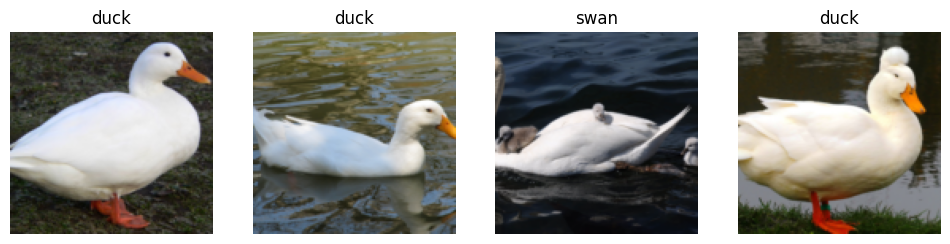

In [50]:
# Load the dataset
dls = waterfowl.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

<h1>Converting images to grayscale</h1>
To ensure the model doesn’t use color as a clue for differentiating the birds, I applied a grayscale transformation to the images.

In [51]:
# Create a custom transformation to convert images to grayscale
class GrayscaleTransform(Transform):
    def encodes(self, img: PILImage):  # Apply the transformation during encoding
        return img.convert("L")  # Convert the image to grayscale (L mode is for black-and-white)

In [52]:
# Define the DataBlock with the custom grayscale transformation
waterfowl_grayscale = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(224), GrayscaleTransform()],  # Resize and apply grayscale
    batch_tfms=aug_transforms()  # Data augmentation
)

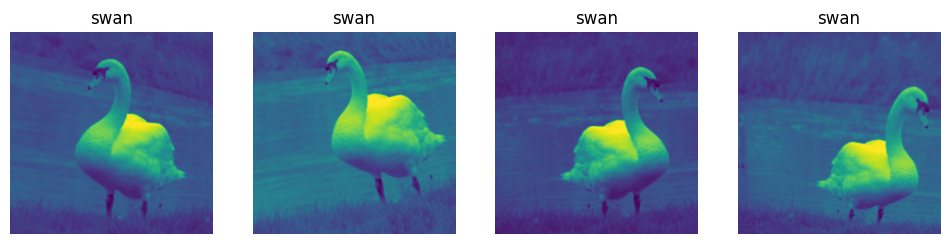

In [53]:
# Load the DataLoader with grayscale images
dls_grayscale = waterfowl_grayscale.dataloaders(path)
dls_grayscale.train.show_batch(max_n=4, nrows=1, unique=True)

<h1>Training the AI model</h1>
I trained a ResNet18 model using the grayscale images. This convolutional neural network is well-suited for image classification tasks.

In [54]:
# Train the learner using ResNet18 and grayscale images
learn = vision_learner(dls_grayscale, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.700785,2.479838,0.821429,00:07


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,2.503075,2.141722,0.821429,00:06
1,2.223860,1.733853,0.714286,00:07
2,1.969029,1.323703,0.607143,00:06
3,1.734927,0.946677,0.428571,00:06
4,1.527373,0.726042,0.285714,00:06
5,1.366301,0.638236,0.214286,00:05
6,1.216571,0.596870,0.178571,00:06
7,1.106274,0.585065,0.178571,00:06
8,1.020823,0.582861,0.142857,00:06
9,0.953308,0.585715,0.142857,00:06


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes sh

<h1>Evaluating the model</h1>
After training the model, I evaluated its performance by visualizing the confusion matrix and analyzing where the model made mistakes. See, even the model was confused sometimes.

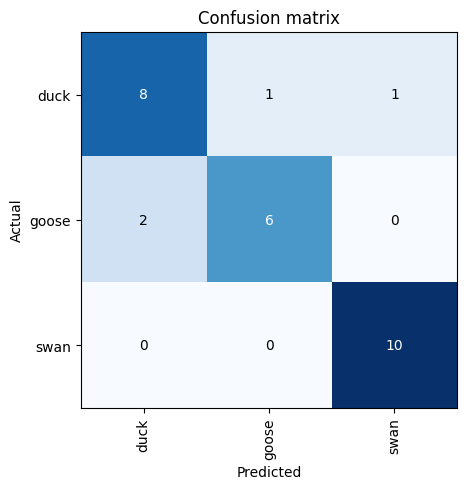

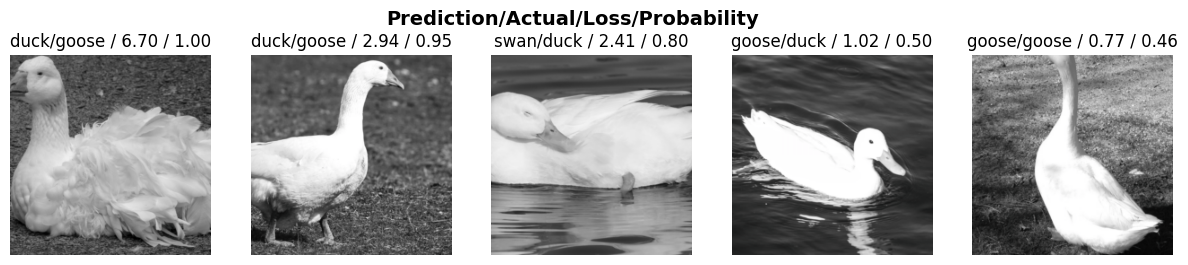

In [55]:
# Model interpretation: confusion matrix and top losses
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

<h1>Making predictions</h1>
Finally, I tested the model by asking it to predict whether an image was of a duck, goose, or swan. The results were impressive!

In [8]:
# Make a prediction on the downloaded 'duck.jpg' image
is_duck, _, probs = learn.predict(PILImage.create('duck.jpg'))
print(f"This waterfowl is: {is_duck}.")
print(f"Probability it's a duck: {probs[0]:.4f}")

NameError: name 'learn' is not defined

In [61]:
learn.export()

In [62]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [63]:
learn_inf = load_learner(path/'export.pkl')

In [65]:
learn_inf.predict('duck.jpg')

('duck', tensor(0), tensor([9.9566e-01, 4.3328e-03, 7.5762e-06]))

In [66]:
learn_inf.dls.vocab

['duck', 'goose', 'swan']

In [6]:
!pip install gradio
import gradio as gr

learn_inf = load_learner('export.pkl')  # Make sure your model is saved as export.pkl

def predict_image(img):
    pred, pred_idx, probs = learn_inf.predict(img)
    return {learn_inf.dls.vocab[i]: float(probs[i]) for i in range(len(probs))}

# Create the Gradio interface
interface = gr.Interface(fn=predict_image, inputs=gr.Image(type="pil"), outputs=gr.Label())

# Launch the interface locally to test
interface.launch()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 67.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 88.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.8.1 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have goog

NameError: name 'load_learner' is not defined

<h1>Conclusion</h1>
In the end, my AI model confirmed what Google had already told me: white ducks and white geese are not the same animals. But now, I have a cool AI tool that can tell the difference between ducks, geese, and swans with great accuracy!